# Formalia:

Please read the [assignment overview page](https://github.com/suneman/socialgraphs2025/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday September 30th, 2025 at 23:55. Hand in your IPython notebook file (with extension `.ipynb`) via DTU Learn

# Assignment 1.1: Exploring WS and BA models

This first part draws on the Watts-Stogatz and Barabasi-Albert models from Week 3. You should provide solutions to the exercises with the following titles from **Part 1** 

* *Did you really read the text? Answer the following questions (no calculations needed) in your IPython notebook*

* *WS edition*

And from **Part 2**

* *BA Edition*.
  * **Note**: The second part of this exercise (after the questions to the text) first has you build a BA network step-by-step, but doesn't ask any questions. For that part, I would simply like you to write well-documented code that shows how you build the network. 


## Part 2 - BA models

* What are the three slope dependent regimes of complex networks with power-law degree distributions? Briefly describe each one. (You will have to skim chp 4.7 to answer this one).
    * **Anomalous Regime (y <= 2)** - the number of links connected to the largest hub grows as fast as the size of the network (the degree of the largest hub must exceed the total nr of nodes in the network), meaning it will run out of nodes to connect to
    * **Scale-Free Regime (2 < y <3**) - a network where most nodes have very few links and a few nodes have a ton of links. Those hubs act as shortcuts, so any two nodes are only a handful of steps apart (ultra-small world).
    * **Random Network Regime (y > 3)** - hubs are smaller and rearer, degrees are more balanced. Both the first and second moments are finite, for large y the degree distribution decays sufficiently fast to make the hubs small and less numerous. They are hard to distinguish from a random network. 


<!--  -->
* What are the three regimes we find in non-linear preferential attachement? (chapter 5) Briefly describe each one.
    * **Sublinear (alfa < 1)** - weak rich-get-richer, meaning high-degree nodes aren't favored strongly, no mega hubs
    * **Linear (alfa=1)** - exact rich-get-richer, meaning the people with more connections are more likely to get even more connections (grow), clear hubs
    * **Superlinear (alfa < 1)** - too strong rich get richer - popular nodes are favored too strongly, one dominant hub emerges. 
    

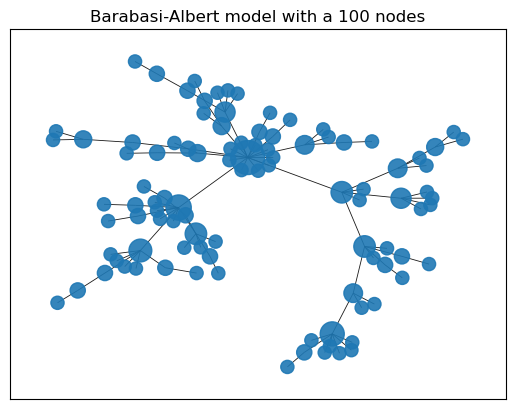

In [27]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np

# To make randomness reproducible for run
random.seed(42)
np.random.seed(42)

# Creating a graph
G = nx.Graph()
G.add_edge(0,1)

next_node = 2

while G.number_of_nodes() < 100:
    G.add_node(next_node)
    
    # Builds a list of edge endpoints, nodes appear as many times as their degree
    edge_ends = [n for (u,v) in G.edges() for n in (u,v)]

    # Picking a random target
    target = random.choice(edge_ends)

    # Attaching the new node to the target
    G.add_edge(next_node, target)
    next_node +=1

pos = nx.spring_layout(G, seed=7)
deg = dict(G.degree())
node_sizes = [60 + 30 * deg[n] for n in G.nodes()] # build the node sizes for plotting based on each node's degree

plt.figure()
nx.draw_networkx(G, pos=pos, node_size=node_sizes, with_labels=False, width=0.6, alpha=0.9)
plt.title("Barabasi-Albert model with a 100 nodes")
plt.show()


Minimum degree: 1
Maximum degree: 134


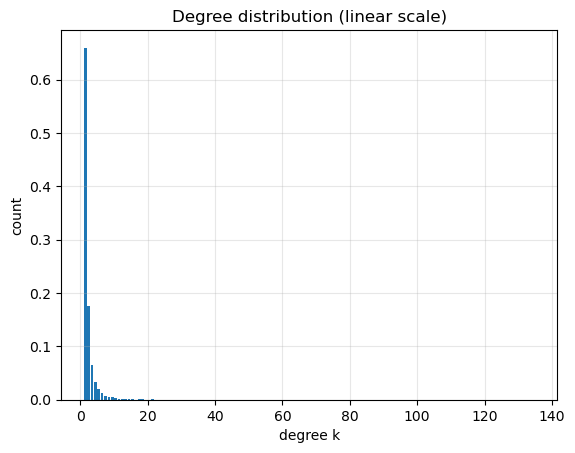

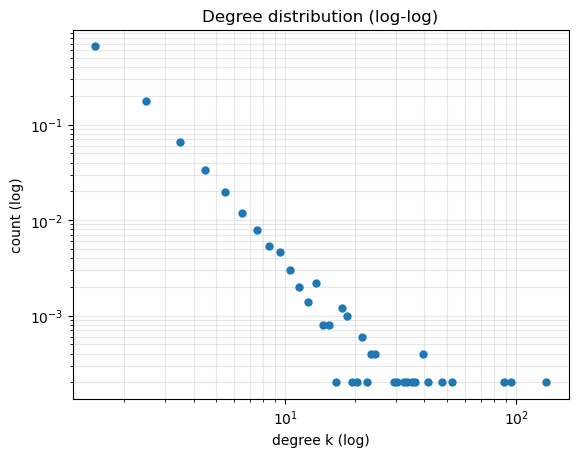

In [28]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np

# To make randomness reproducible for run
random.seed(42)
np.random.seed(42)

# Creating a graph
G = nx.Graph()
G.add_edge(0,1)

next_node = 2

while G.number_of_nodes() < 5000:
    G.add_node(next_node)
    
    # Builds a list of edge endpoints, nodes appear as many times as their degree
    edge_ends = [n for (u,v) in G.edges() for n in (u,v)]

    # Picking a random target
    target = random.choice(edge_ends)

    # Attaching the new node to the target
    G.add_edge(next_node, target)
    next_node +=1


# What is the maximum and minimum degree?
degree_values = [d for _, d in G.degree()]
deg_min = min(degree_values) # minimum degree
deg_max = max(degree_values) # maximum degree
print(f"Minimum degree: {deg_min}")
print(f"Maximum degree: {deg_max}")


# Binning with numpy.histogram 
bins = np.arange(deg_min, deg_max+2)
counts, bin_edges = np.histogram(degree_values, bins=bins, density=True)

# Using bin center for plotting at the degree values
k_vals = (bin_edges[:-1] + bin_edges[1:]) / 2.0


# Plotting the distribution with linear axes
plt.figure()
plt.bar(k_vals, counts, width=0.8, align='center')
plt.xlabel("degree k")
plt.ylabel("count")
plt.title("Degree distribution (linear scale)")
plt.grid(True, alpha=0.3)
plt.show()


# Plotting the distribution with log-log axes
mask = (counts > 0) & (k_vals > 0)
plt.figure()
plt.loglog(k_vals[mask], counts[mask], "o", ms=5)
plt.xlabel("degree k (log)")
plt.ylabel("count (log)")
plt.title("Degree distribution (log-log)")
plt.grid(True, which="both", alpha=0.3)
plt.show()



# Assignment 1.2: Stats and visualization of the Rock Music Network

This second part requires you to have built the network of Rock Musicians as described in the exercises for Week 4. You should complete the following exercise from **Part 2**.

* *Explain your process in words*

* *Simple network statistics and analysis*.

  * **Note related to this and the following exercise**. It is nice to have the dataset underlying the statistics and visualization available when we grade. Therefore, I recommend that you create a small *network dataset*, which is simply your graph stored in some format that you like (since it's only a few hundred nodes and a few thousand edges, it won't take up a lot of space). You can then place that network one of your group members' GitHub account (or some other server that's available online) and have your Jupyter Notebook fetch that dataset when it runs. (It's OK to use an LLM for help with setting this up, if it seems difficult). 

And the following exercise from **Part 3**

* *Let's build a simple visualization of the network*

And that's it! You're all set.

# Assignment 1.2
## Setting up the Graph
### Part 1: Defining some function for easier link extraction using regular expressions
We define three function in this part:
1. get_links: This function extracts the links from a page.
2. sanitize_string: This function sanitizes the links from a link. This basically just formats the way we save the links. As some band names would hurt the OS conventions, thus we couldn't save the corresponding musician name in a file. For example: 'AC/DC'.
3. sanitize_list: This function just sanitizes a list of strings.

In [1]:
import re

from tornado.queues import Queue


def get_links(page: str) -> list:
    return re.findall(r"\[\[([^\[\]]*)\]\]",page)

def sanitize_string(name: str) -> str:
    return name.replace('/','_').replace(' ','_')

def sanitize_list(names: list[str]) -> list[str]:
    return [sanitize_string(x) for x in names]

### Part 2: Calling Wikipedia API and Extracting the Wikitext of the Main Page
We define an another function for extracting the wikitext of a wikipedia page.

In [2]:
import requests

API = "https://en.wikipedia.org/w/api.php"
HEADERS = {"User-Agent": "MyWikipediaClient/1.0 (example@example.com)"}


# This method is based on this: https://stackoverflow.com/a/62225015 and this line was partly done with ChatGPT data["query"]["pages"][0]["revisions"][0]["slots"]["main"]["content"].
def get_wikitext(title: str) -> str:
    params = {
        "action": "query",
        "prop": "revisions",
        "titles": title,
        "rvslots": "main",
        "rvprop": "content",
        "format": "json",
        "formatversion": "2",
    }

    response = requests.get(API, params=params, headers=HEADERS, timeout=20)
    response.raise_for_status()

    data = response.json()

    return data["query"]["pages"][0]["revisions"][0]["slots"]["main"]["content"]

In [52]:
main_page = get_wikitext('List of mainstream rock performers')
print(main_page[0:100] + "\n")

rock_pages = re.findall(r'\[\[([^\[\]]*)\]\]', main_page)

rock_pages = sanitize_list(rock_pages)
print(rock_pages[0:10])

{{short description|None}}

This is an alphabetical '''list of mainstream rock performers''' spannin

['rock_music', '10cc', '10_Years_(band)|10_Years', '3_Doors_Down', '311_(band)|311', '38_Special_(band)|.38_Special', 'ABBA', 'Accept_(band)|Accept', 'AC_DC', 'Bryan_Adams']


### Part 3: Downloading the Pages and Extracting the Links from those Pages
Download pages:
**Remark:** This part can take a while to execute. (Reference: ran 3-5 minutes locally)

In [3]:
import os

for musician in rock_pages:
    musician_page = get_wikitext(musician)

    os.makedirs("./Misc/RockPages", exist_ok=True)

    with open(f'./Misc/RockPages/{musician}.txt', 'w') as output:
        output.write(musician_page)

print(os.listdir('./Misc/RockPages'))

NameError: name 'rock_pages' is not defined

Extracting links:


In [54]:
import networkx as nx

G = nx.DiGraph()
musicians = os.listdir('./Misc/RockPages')

for musician in musicians:
    with open(f'./Misc/RockPages/{musician}') as f:
        text = f.read()

    # Remove .txt from the end
    p_name = os.path.splitext(musician)[0]

    # It is actually important to add it here too, as some musicians have no links to other musicians
    # Furthermore, it is just easier to save the length of page here
    G.add_node(p_name, attr=len(text.split()))

    links = get_links(text)
    links = sanitize_list(links)

    # Only save edges where the link goes to a musician
    filtered_links = [link for link in links if link + ".txt" in musicians]
    print(filtered_links)

    for link in filtered_links:
        G.add_edge(p_name,link)

['Parliament-Funkadelic', 'AllMusic', 'Jimi_Hendrix', 'Parliament-Funkadelic', 'Sly_and_the_Family_Stone', 'Parliament-Funkadelic', 'Cream_(band)|Cream']
['Metallica', 'Megadeth', 'Anthrax_(American_band)|Anthrax', 'Iron_Maiden', 'Black_Sabbath', 'Judas_Priest', 'AllMusic', 'Scorpions_(band)|Scorpions', 'Iron_Maiden', 'Megadeth', 'AllMusic', 'Judas_Priest', 'Motörhead', 'Megadeth', 'Anthrax_(American_band)|Anthrax', 'Alice_in_Chains', 'Metallica', 'Ozzy_Osbourne', 'Sepultura', 'Black_Sabbath', 'Pantera', 'Tool_(band)|Tool', 'Slipknot_(band)|Slipknot', 'Metallica', 'Lamb_of_God_(band)|Lamb_of_God', 'Trivium_(band)|Trivium', 'Megadeth', 'Anthrax_(American_band)|Anthrax', 'Anthrax_(American_band)|Anthrax', 'Lamb_of_God_(band)|Lamb_of_God', 'Lamb_of_God_(band)|Lamb_of_God', 'Anthrax_(American_band)|Anthrax', 'Primus_(band)|Primus', 'Anthrax_(American_band)|Anthrax', 'Volbeat', 'Metallica', 'Megadeth', 'Black_Sabbath', 'AllMusic', 'AllMusic', 'Black_Sabbath', 'Motörhead', 'Judas_Priest', 'I

Remove disconnected nodes:

In [55]:
print(f"The graph before cutting:\n{G}")
nodes = list(G.nodes())

for node in nodes:
    if G.in_degree(node) == 0 and G.out_degree(node) == 0:
        G.remove_node(node)
        print(node)

print(f"The graph after cutting:\n{G}")

The graph before cutting:
DiGraph with 492 nodes and 7004 edges
Kaleo_(band)|Kaleo
Dr._Hook_&_the_Medicine_Show
Shakin'_Stevens
Category:Lists_of_rock_musicians
Van_Zant_(band)
Stevie_Ray_Vaughan|Stevie_Ray_Vaughan_and_Double_Trouble
Bread_(band)|Bread
Jet_(Australian_band)|Jet
Category:Lists_of_rock_musicians_by_subgenre
The graph after cutting:
DiGraph with 483 nodes and 7004 edges


Saving the network:

In [56]:
import pickle

pickle.dump(G, open('Misc/MusicianGraph.pickle', 'wb'))

For easier grading:

In [57]:
from io import BytesIO

url = 'https://raw.githubusercontent.com/hoboldi/Social-Graphs-and-Interactions/main/Misc/MusicianGraph.pickle'
r = requests.get(url)
r.raise_for_status()

G = pickle.load(BytesIO(r.content))
print(G)

DiGraph with 483 nodes and 7004 edges


Extracting the largest connected component:

In [58]:
LCG = max(nx.weakly_connected_components(G), key=len)
LCG = G.subgraph(LCG).copy()

**Excercise:**
- Document how you crawled the network.
    - See above comments and markdown texts.
- First, simply describe the steps of the process (what you did, step by step)
    - See above comments and markdown texts.
- Then, write a short section about which part of the process that was most difficult
    - Achieving clean Wikitext pages was not difficult, but finding the correct approach took a long time.
    - As I (we) have worked with regular expression previously, that part was not that hard.
    - Networkx has a lot of convenient functions, so working with it was also not that complicated, but sometimes it took a long time trying something before realizing NetworkX has already a function for that.
- Next write a short section about how you used LLMs to help you
    - It helped a lot for the API part. Furthermore, it was useful for getting to know the syntax.
- Finally, compose a short section about what you would do differently if you had to do it again.
    - TODO.

## Network Statistics and Analysis
- What is the number of nodes in the network?
- More importantly, what is the number of links?

In [59]:
print(LCG)

DiGraph with 483 nodes and 7004 edges


- Plot the in and out-degree distributions for the entire network. What do you observe? Can you explain why the in-degree distribution is different from the out-degree distribution?

7004
7004


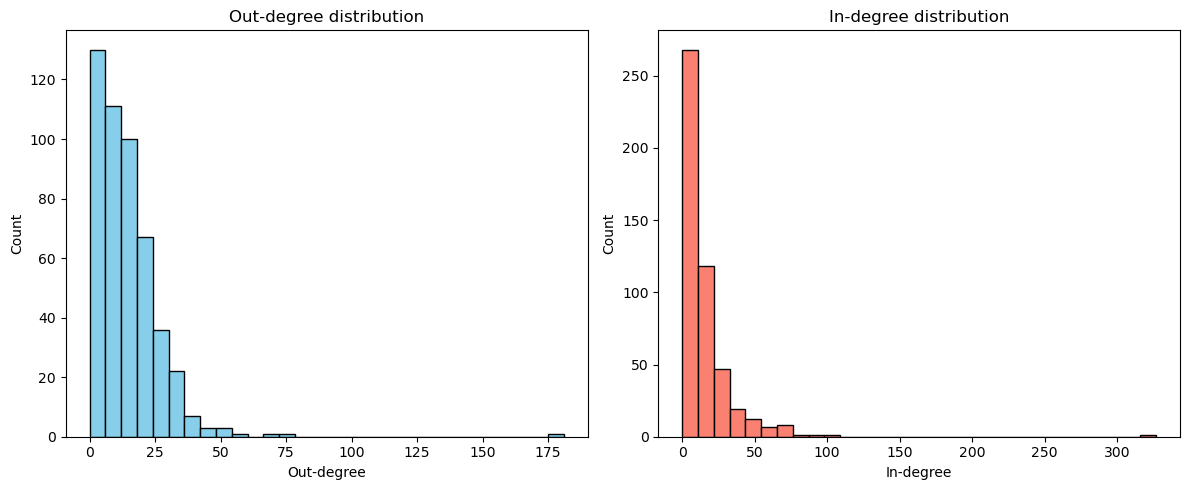

In [61]:
import matplotlib.pyplot as plt

in_degrees  = [d for _, d in LCG.in_degree()]
out_degrees = [d for _, d in LCG.out_degree()]

print(sum(in_degrees))
print(sum(out_degrees))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(out_degrees, bins=30, color="skyblue", edgecolor="black")
plt.title("Out-degree distribution")
plt.xlabel("Out-degree")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(in_degrees, bins=30, color="salmon", edgecolor="black")
plt.title("In-degree distribution")
plt.xlabel("In-degree")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

**Explanation:**
- There is a select few bands who are the most influential. These influenced the most bands on the list.
- This explains why there is fewer "low in-degree bands", but more "high in-degree bands".
- Most bands reference these select few.
- This explains the lower variance of the out-degree distribution.
- This is the typical phenomenon discovered by Barabási-Albert László.
- These are the Hubs of this network.

- Compare the out-degree distribution to a *random network* with the same number of nodes and links.

DiGraph with 483 nodes and 7004 edges


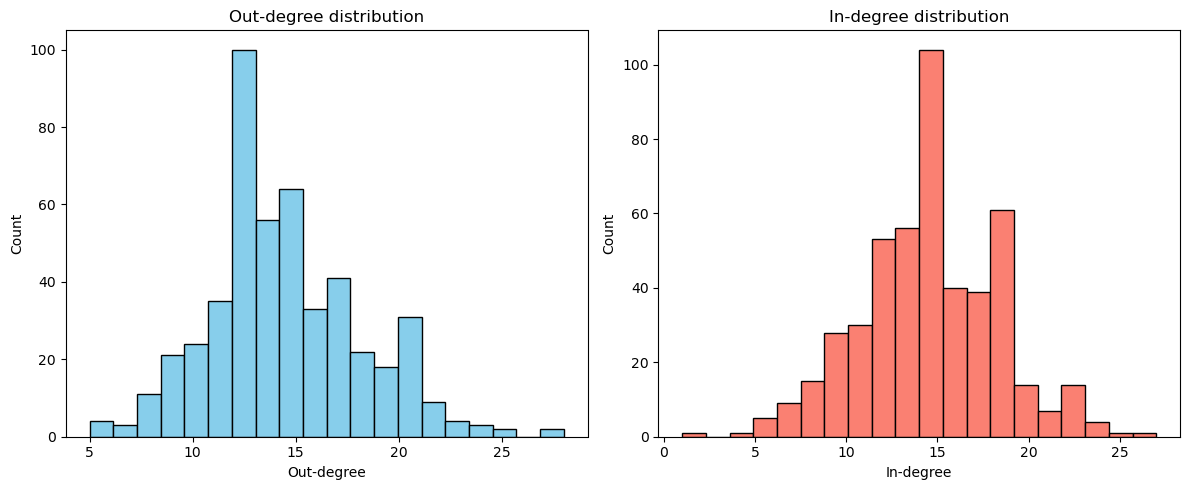

In [74]:
random = nx.gnm_random_graph(n=LCG.number_of_nodes(),m=LCG.number_of_edges(),directed=True)
print(random)

in_degrees  = [d for _, d in random.in_degree()]
out_degrees = [d for _, d in random.out_degree()]

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(out_degrees, bins=20, color="skyblue", edgecolor="black")
plt.title("Out-degree distribution")
plt.xlabel("Out-degree")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(in_degrees, bins=20, color="salmon", edgecolor="black")
plt.title("In-degree distribution")
plt.xlabel("In-degree")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

**Comparison:**
- The distribution of the out-degrees is vastly different compared to our network.
- TODO

- Compare the in-degree distribution to a *scale-free* network with the same number of nodes.

Graph with 483 nodes and 7020 edges


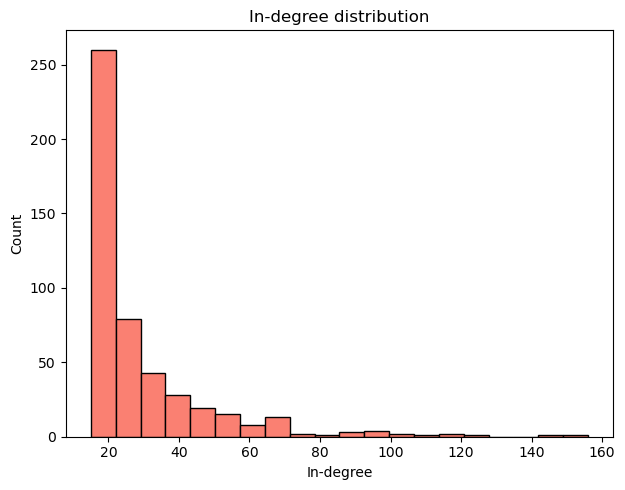

In [75]:
n = LCG.number_of_nodes()
m = LCG.number_of_edges()/LCG.number_of_nodes()

scale_free = nx.barabasi_albert_graph(n=n, m=int(round(m)))
print(scale_free)

in_degrees  = [d for _, d in scale_free.degree()]

plt.figure(figsize=(12,5))

plt.subplot(1,2,2)
plt.hist(in_degrees, bins=20, color="salmon", edgecolor="black")
plt.title("In-degree distribution")
plt.xlabel("In-degree")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

**Comparison:**
- This is much more similar to our network.
- TODO

- Who are the top 5 most connected performers (Report results for in-degrees and out-degrees, that is, who has highest in-degree, who has highest out-degree)? Comment on your findings. Is this what you would have expected?

In [90]:
# These lambda expressions were generated by ChatGPT as my implementation was much longer and not so nice.
top_in = sorted(LCG.in_degree(), key=lambda x: x[1], reverse=True)[:5]
top_out = sorted(LCG.out_degree(), key=lambda x: x[1], reverse=True)[:5]

print("In-degree:")
for node, deg in top_in:
    print(f"{node}: {deg}")

print()

print("Out-degree:")
for node, deg in top_out:
    print(f"{node}: {deg}")

print()

In-degree:
AllMusic: 327
Led_Zeppelin: 108
Bob_Dylan: 90
Queen_(band)|Queen: 80
Metallica: 76

Out-degree:
rock_music: 181
Alice_in_Chains: 74
Deep_Purple: 72
Black_Sabbath: 59
Guns_N'_Roses: 49



**Explanation:**
- TODO

- What are the 10 pages with the longest wiki entries? (use the `length of content` attribute to figure this one out)?

In [91]:
# This lambda expression was generated by ChatGPT as my implementation was much longer and not so nice.
pages = sorted(
    LCG.nodes(data=True),
    key=lambda x: list(x[1].values())[0],  # grab the only attribute value
    reverse=True
)[:10]

print(pages)

[('Bob_Dylan', {'attr': 30646}), ("Guns_N'_Roses", {'attr': 29711}), ('Paul_McCartney', {'attr': 27322}), ('The_Rolling_Stones', {'attr': 26186}), ('Chicago_(band)|Chicago', {'attr': 25975}), ('Europe_(band)|Europe', {'attr': 25273}), ('David_Bowie', {'attr': 24905}), ('Elton_John', {'attr': 24904}), ('U2', {'attr': 24877}), ('The_Beach_Boys', {'attr': 24844})]
